# Brain Tumor Classification

In this notebook I will be working with the following [Brain Tumor Dataset](https://www.kaggle.com/preetviradiya/brian-tumor-dataset). It contains X-Ray images of brain divided into two categories: brains with cancer and healthy brains. My goal is to build Deep Learning classifier that learns to label brain X-Rays as either healthy or having a cancer.

I treat this exercise as a practice in building deep learning model with PyTorch framework. Therefore, I will experiment with different neural network architectures. First, I will build a simple base model from scratch, then I will move to more sophisticated architectures, and utilize transfer learning to compare performance of some of the most popular models (vgg-16, LeNet, etc.) and obtain optimal performance.

# Imports

In [1]:
import os
import shutil
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary

# Data Preprocessing

Before we start with any preprocessing steps, we will reorganize our files structure

In [2]:
data_path = 'data/Brain Tumor Data Set'
orig_dirs = [dir for dir in os.listdir(data_path)]

# New directories to be created
orig_imgs_dir = 'Original Data Set'
prep_imgs_dir = 'Preprocessed Data Set'

# Paths to new directories
orig_imgs_path = os.path.join(data_path, orig_imgs_dir)
prep_imgs_path = os.path.join(data_path, prep_imgs_dir)

# Create new directories
os.mkdir(orig_imgs_path)
os.mkdir(prep_imgs_path)

# Move original data set to the corresponding directory
for dir in orig_dirs:
    shutil.move(os.path.join(data_path, dir), orig_imgs_path)

# Create new directories for preprocessed images
prep_tumor_dir = 'Prep Brain Tumor' 
prep_healthy_dir = 'Prep Healthy'

prep_tumor_imgs_path = os.path.join(prep_imgs_path, prep_tumor_dir)
prep_healthy_imgs_path = os.path.join(prep_imgs_path, prep_healthy_dir)

os.mkdir(prep_tumor_imgs_path)
os.mkdir(prep_healthy_imgs_path) 

We will plot some of the images to get a general understanding of our dataset and decide if any preprocessing techniques should be applied. Let's define functions for loading and plotting.

In [3]:
def load_samples(data_path, num):
    """ Loads {num} sample images for each category. """

    imgs = []
    lbls = []
    
    for root, _, files in os.walk(data_path):
        for idx, filename in enumerate(files):
            filepath = root + os.sep + filename
            img = cv2.imread(filepath)
            imgs.append(img)
            label = root.split('\\')[-1]
            lbls.append(label)
            if idx+1 == num: break
            
    return imgs, lbls


def plot_samples(data_path, num=10):
    """ Plots {num} sample images for each category. """
    
    imgs, lbls = load_samples(data_path, num)
    ncols = 10
    nrows = int(2*num/ncols)

    plt.figure(figsize=(20, 10))
    for idx, (img, label) in enumerate(zip(imgs, lbls)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.imshow(img)
        plt.xlabel(label)
        plt.xticks([])
        plt.yticks([])
    
    plt.show()

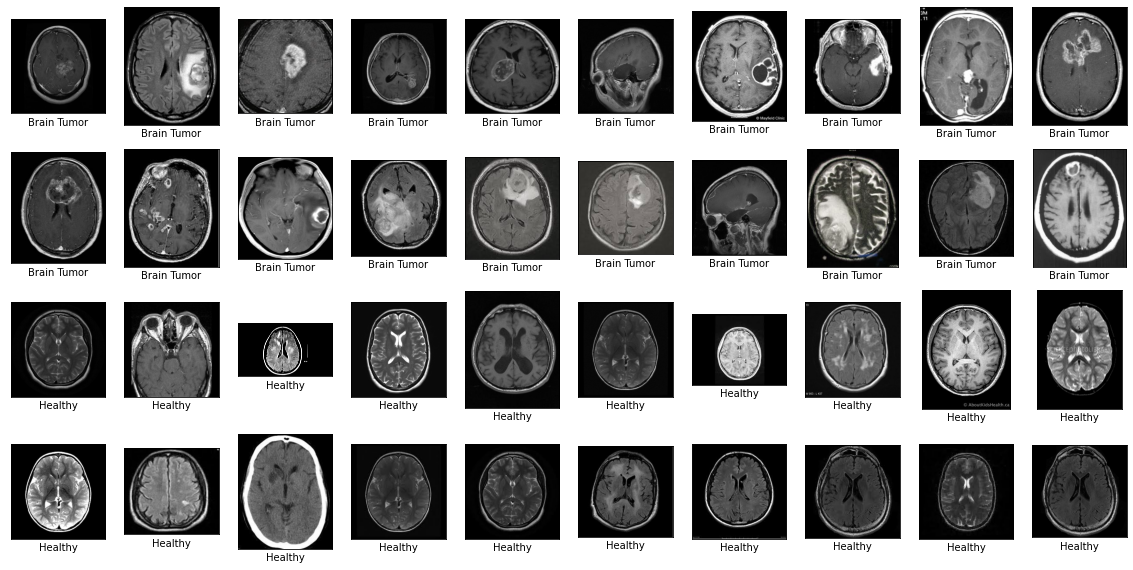

In [4]:
plot_samples(orig_imgs_path, 20)

As we can see, the images differ in width and heigth, we will handle this using transforms.Resize() later during Data Loading step. 
I want to crop the images, so that the dark background will be the maximum bounding rectangle of the actual brain image. This will normalze width/heigth ratios of the images, should prevent some wide images from looking 'strange' after resizing, and also makes our model 'focus' only on the brain part of the X-Rays.

In [5]:
def crop_images(data_path):
    for root, _, files in os.walk(data_path):
        label = root.split('\\')[-1]
        
        for filename in files:
            filepath = root + os.sep + filename
                
            img = cv2.imread(filepath)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            thresh = cv2.adaptiveThreshold(blurred, 255, 
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 2)

            # Perform closing operation 
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
            closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

            # Find the biggest contour (brain contour)
            cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            brain_cnt = max(cnts, key = cv2.contourArea)
                
            # Crop the brain image
            (x, y, w, h) = cv2.boundingRect(brain_cnt)
            brain_img = img[y:y + h, x:x + w]

            filename = 'prep_{f}'.format(f=filename)
                
            # Save preprocessed image to the right directory,
            # depending on its label
            if label == orig_dirs[0]: # CONSIDER REPLACING THIS TEST LATER
                cv2.imwrite(os.path.join(prep_tumor_imgs_path, filename), brain_img)
            else:
                cv2.imwrite(os.path.join(prep_healthy_imgs_path, filename), brain_img)

In [6]:
crop_images(orig_imgs_path)  

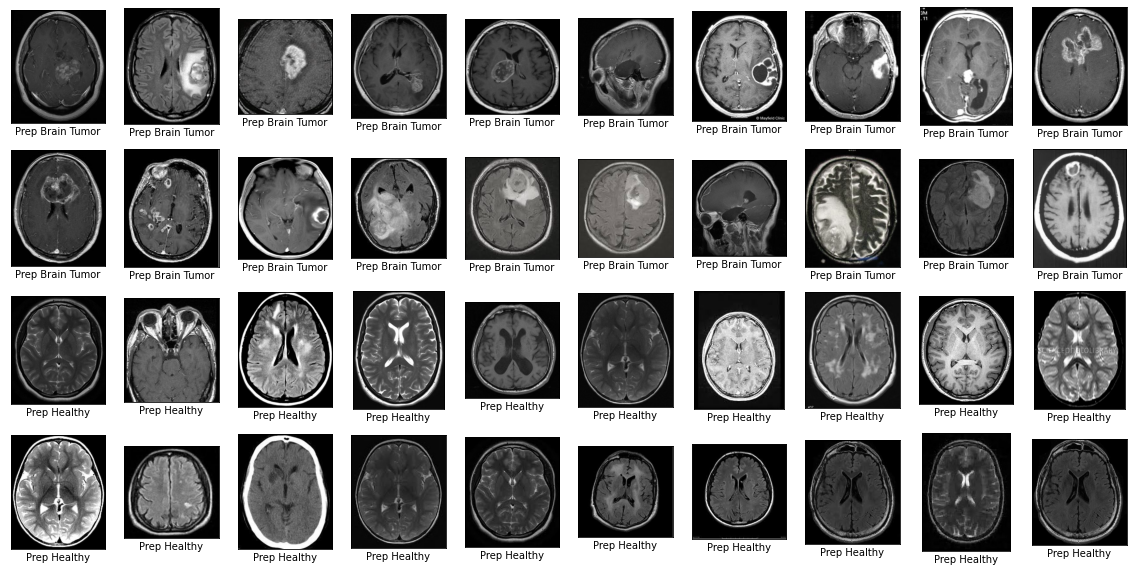

In [7]:
# Plot preprocessed images
plot_samples(prep_imgs_path, 20)

# Data Loading

In [ ]:
train_transform = transforms.Compose([transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC), 
                                      transforms.ColorJitter(brightness=(0.1, 1.5)), 
                                      transforms.RandomRotation(10), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomVerticalFlip(), 
                                      transforms.ToTensor()])

val_transform = transforms.Compose([transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
                                    transforms.ToTensor()])
                                    

train_dataset = torchvision.datasets.ImageFolder(prep_imgs_path, train_transform)
val_dataset = torchvision.datasets.ImageFolder(prep_imgs_path, val_transform)


# Create the index splits for training and validation
train_size = 0.8
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
np.random.shuffle(indices)
train_idx, val_idx = indices[:split], indices[split:]

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=val_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)